<a href="https://colab.research.google.com/github/abisubramanya27/CS6910_Assignment3/blob/master/src/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading dataset and unzipping

In [ ]:
!wget "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

--2021-05-06 12:38:10--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.217.15.80, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   147MB/s    in 11s     

2021-05-06 12:38:22 (172 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [ ]:
!tar xopf dakshina_dataset_v1.0.tar

In [ ]:
!ls dakshina_dataset_v1.0/hi/lexicons

hi.translit.sampled.dev.tsv   hi.translit.sampled.train.tsv
hi.translit.sampled.test.tsv


# Reading and processing data

In [ ]:
import numpy as np

def read_data(data_path, characters = False):
    # Returns the (input, output) pair from the dataset
    # If characters == True, the input/output would be in the form list of characters, else as string

    with open(data_path, "r", encoding="utf-8") as f:
        lines = [line.split("\t") for line in f.read().split("\n") if line != '']
    
    input, target = [val[1] for val in lines], [val[0] for val in lines]
    if characters:
        input, target = [list(inp_str) for inp_str in input], [list(tar_str) for tar_str in target]
    return input, target


def process_data(input, enc_timesteps, input_char_enc, target = None, dec_timesteps = None, target_char_enc = None):
    # Returns the input and target data in a form needed by the Keras embedding layer, where each character is encoded by an integer

    # ' ' -- space (equivalent to no meaningful input)
    encoder_input = np.array([[input_char_enc[ch] for ch in string] + [input_char_enc[' ']] * (enc_timesteps - len(string)) for string in input])

    decoder_input, decoder_target = None, None
    if target is not None and dec_timesteps is not None and target_char_enc is not None:
        # '\t' -- start of sequence, '\n' -- end of sequence
        decoder_input = np.array([[target_char_enc['\t']] + [target_char_enc[ch] for ch in string] + [target_char_enc['\n']] 
                                    + [target_char_enc[' ']] * (dec_timesteps - len(string) - 2) for string in target])
        decoder_target = np.zeros((decoder_input.shape[0], dec_timesteps, len(target_char_enc)), dtype='float32')

        for i in range(decoder_input.shape[0]):
            for t, char_ind in enumerate(decoder_input[i]):
                if t > 0:
                    decoder_target[i,t-1,char_ind] = 1.0
            decoder_target[i,t:,target_char_enc[' ']] = 1.0

    return encoder_input, decoder_input, decoder_target


def encode_decode_characters(train_input, train_target, val_input, val_target):
    # Returns the encoder for characters to integer (as a dictionary) and decoder for integers to characters (as a list) for input and target data

    input_char_enc = {}
    input_char_dec = []
    max_encoder_seq_length = 1
    for string in train_input + val_input:
        max_encoder_seq_length = max(max_encoder_seq_length, len(string))
        for char in string:
            if char not in input_char_enc:
                input_char_enc[char] = len(input_char_dec)
                input_char_dec.append(char)
    if ' ' not in input_char_enc:
        input_char_enc[' '] = len(input_char_dec)
        input_char_dec.append(' ')

    target_char_enc = {}
    target_char_dec = []
    target_char_enc['\t'] = len(target_char_dec)
    target_char_dec.append('\t')
    max_decoder_seq_length = 1
    for string in train_target + val_target:
        max_decoder_seq_length = max(max_decoder_seq_length, len(string)+2)
        for char in string:
            if char not in target_char_enc:
                target_char_enc[char] = len(target_char_dec)
                target_char_dec.append(char)
    target_char_enc['\n'] = len(target_char_dec)
    target_char_dec.append('\n')
    if ' ' not in target_char_enc:
        target_char_enc[' '] = len(target_char_dec)
        target_char_dec.append(' ')

    print("Number of training samples:", len(train_input))
    print("Number of validation samples:", len(val_input))
    print("Number of unique input tokens:", len(input_char_dec))
    print("Number of unique output tokens:", len(target_char_dec))
    print("Max sequence length for inputs:", max_encoder_seq_length)
    print("Max sequence length for outputs:", max_decoder_seq_length)

    return input_char_enc, input_char_dec, target_char_enc, target_char_dec, max_encoder_seq_length, max_decoder_seq_length

def max_seq_length(data):
    max_len = 0
    for word in data:
        max_len = max(max_len, len(word))
    
    return max_len


In [ ]:
input_char_enc = {}
input_char_dec = []
target_char_enc = {}
target_char_dec = []
max_encoder_seq_length = 0
max_decoder_seq_length = 0

# Reading training, validation and test data
train_inp, train_out = read_data('./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv')
val_inp, val_out = read_data('./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv')
test_inp, test_out = read_data('./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv')
# Assigning encoding and decoding for input and target characters
input_char_enc, input_char_dec, target_char_enc, target_char_dec, max_encoder_seq_length, max_decoder_seq_length = encode_decode_characters(
    train_inp, train_out, val_inp, val_out)

# Assigning training, validation and test encoder input, decoder input, decoder output
train_enc_input, train_dec_input, train_dec_target = process_data(train_inp, max_encoder_seq_length, input_char_enc, train_out, 
                                                                  max_decoder_seq_length, target_char_enc)
val_enc_input, val_dec_input, val_dec_target = process_data(val_inp, max_encoder_seq_length, input_char_enc, val_out, 
                                                            max_decoder_seq_length, target_char_enc)
test_enc_input, test_dec_input, test_dec_target = process_data(test_inp, max_encoder_seq_length, input_char_enc, test_out, 
                                                               max_decoder_seq_length, target_char_enc)


Number of training samples: 44204
Number of validation samples: 4358
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21


# Seq2Seq Model (without Attention)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

def create_model(encoder_vocab_size, decoder_vocab_size, inp_emb_size=16, no_enc_layers=1, no_dec_layers=1, 
                 hid_layer_size=32, cell_type='LSTM', dropout=0, r_dropout=0, cell_activation='tanh'):
    
    get_cell = {
        'RNN': keras.layers.SimpleRNN,
        'GRU': keras.layers.GRU,
        'LSTM': keras.layers.LSTM
    }
    # Encoder input and embedding
    encoder_input = keras.layers.Input(shape=(None,), name="input_1")
    encoder_inp_emb = keras.layers.Embedding(encoder_vocab_size, inp_emb_size, name="embedding_1")(encoder_input)

    # Encoder cell layers
    encoder_seq, *encoder_state = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                                      dropout=dropout, recurrent_dropout=r_dropout, name="encoder_1")(
                                                            encoder_inp_emb
                                                     )
    for i in range(1, no_enc_layers):
        encoder_seq, *encoder_state = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                                          dropout=dropout, recurrent_dropout=r_dropout, name="encoder_"+str(i+1))(
                                                                encoder_seq
                                                         )
    
    # Decoder input and embedding
    decoder_input = keras.layers.Input(shape=(None,), name="input_2")
    decoder_inp_emb = keras.layers.Embedding(decoder_vocab_size, inp_emb_size, name="embedding_2")(decoder_input)

    # Decoder cell layers
    decoder_seq, *_ = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                          dropout=dropout, recurrent_dropout=r_dropout, name="decoder_1")(
                                                decoder_inp_emb, initial_state=encoder_state
                                         )
    for i in range(1, no_dec_layers):
        decoder_seq, *_ = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                              dropout=dropout, recurrent_dropout=r_dropout, name="decoder_"+str(i+1))(
                                                    decoder_seq, initial_state=encoder_state
                                             )
    
    # Softmax FC layer
    decoder_dense_output = keras.layers.Dense(decoder_vocab_size, activation="softmax", name="dense_1")(
        decoder_seq
    )

    # Define the model that will turn encoder_input_data and decoder_input_data into decoder_target_data
    model = keras.Model([encoder_input, decoder_input], decoder_dense_output)

    model.summary()
    return model

In [ ]:
!pip install --upgrade wandb
!wandb login 6746f968d95eb71e281d6c7772a0469574430408

import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 2.1MB 18.6MB/s 
     |████████████████████████████████| 102kB 9.6MB/s 
     |████████████████████████████████| 133kB 43.3MB/s 
     |████████████████████████████████| 163kB 41.0MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=776be7750d2d21b63d2376f4539695dd6a2568854169d0a6ce6ddcb656958cf8
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=d9061fd78929ede2260b9817f057df7af7836730c9c362113eaefd8dd2c74023
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
def create_inference_model(model):
    no_enc_layers, no_dec_layers = 0, 0
    for layer in model.layers:
        no_enc_layers += layer.name.startswith('encoder')
        no_dec_layers += layer.name.startswith('decoder')

    # Encoder input
    encoder_input = model.input[0]      # Input_1
    # Encoder cell final layer
    encoder_cell = model.get_layer("encoder_"+str(no_enc_layers))
    encoder_type = encoder_cell.__class__.__name__
    encoder_seq, *encoder_state = encoder_cell.output
    # Encoder model
    encoder_model = keras.Model(encoder_input, encoder_state)

    # Decoder input
    decoder_input = model.input[1]      # Input_2
    decoder_inp_emb = model.get_layer("embedding_2")(decoder_input)
    decoder_seq = decoder_inp_emb
    # Inputs to decoder layers' initial states
    decoder_states, decoder_state_inputs = [], []
    for i in range(1, no_dec_layers+1):
        if encoder_type == 'LSTM':
            decoder_state_input = [keras.Input(shape=(encoder_state[0].shape[1],), name="input_"+str(2*i+1)), 
                                   keras.Input(shape=(encoder_state[1].shape[1],), name="input_"+str(2*i+2))]
        else:
            decoder_state_input = [keras.Input(shape=(encoder_state[0].shape[1],), name="input_"+str(i+2))]

        decoder_cell = model.get_layer("decoder_"+str(i))
        decoder_seq, *decoder_state = decoder_cell(decoder_seq, initial_state=decoder_state_input)
        decoder_states += decoder_state
        decoder_state_inputs += decoder_state_input

    # Softmax FC layer
    decoder_dense = model.get_layer("dense_1")
    decoder_dense_output = decoder_dense(decoder_seq)

    # Decoder model
    decoder_model = keras.Model(
        [decoder_input] + decoder_state_inputs, [decoder_dense_output] + decoder_states
    )

    return encoder_model, decoder_model, no_enc_layers, no_dec_layers


def convert_to_word(predictions, char_enc, char_dec = None):
    no_samples = len(predictions) if type(predictions) is list else predictions.shape[0]
    pred_words = ['' for _ in range(no_samples)]
    for i, pred_list in enumerate(predictions):
        for l in pred_list:
            # Stop word : '\n'
            if l == char_enc['\n']:
                break
            pred_words[i] += char_dec[l] if char_dec is not None else l
    
    return pred_words


In [ ]:
def beam_decoder_infer(model, input_seqs, max_decoder_timesteps, K=1, target_seqs=None, starting_char_enc=0, batch_size=64, attention=False):
    # K : beam_width
    encoder_model, decoder_model, no_enc_layers, no_dec_layers = create_attention_inference_model(model) if attention else create_inference_model(model)
    encoder_output = encoder_model.predict(input_seqs, batch_size=batch_size)
    encoder_out = encoder_output if type(encoder_output) is list else [encoder_output]

    # Number of input samples in the data passed
    no_samples = input_seqs.shape[0]

    # Top K output sequences for each input 
    final_outputs = np.zeros((no_samples, K, max_decoder_timesteps), dtype=np.int32)
    # Errors for top K output sequences for each input
    final_errors = np.zeros((no_samples, K))
    # Attention scores for top K output sequences for each input
    final_attn_scores = np.zeros((no_samples, K, max_decoder_timesteps, input_seqs.shape[1]))

    # decoder input sequence for 1 timestep (for all samples). Initially one choice only there
    decoder_k_inputs = np.zeros((no_samples, 1, 1))
    # Populate the input sequence with the start character at the 1st timestep
    decoder_k_inputs[:, :, 0] = starting_char_enc

    # (log(probability) sequence, decoder output sequence) pairs for all choices and all samples. Probability starts with log(1) = 0
    decoder_k_out = [[(0, [])] for _ in range(no_samples)]
    # Categorical cross entropy error in the sequence for all choice and all samples
    errors = [[0] for _ in range(no_samples)]
    # Output states from decoder for all choices, and all samples
    states_values  = [encoder_out * no_dec_layers]

    # Attention weights output
    attn_k_scores = [[None] for _ in range(no_samples)]

    # Sampling loop
    for it in range(max_decoder_timesteps):

        All_k_beams = [[] for _ in range(no_samples)]
        All_decoder_states = [[] for _ in range(no_samples)]
        All_errors = [[] for _ in range(no_samples)]
        All_attn_scores = [[] for _ in range(no_samples)]

        for k in range(len(decoder_k_out[0])):
            if attention:
                attn_score, decoder_output, *decoder_states = decoder_model.predict([input_seqs, decoder_k_inputs[:,k]] + states_values[k], batch_size=batch_size)
            else:
                decoder_output, *decoder_states = decoder_model.predict([decoder_k_inputs[:,k]] + states_values[k], batch_size=batch_size)

            # Top K scores
            top_k = np.argsort(decoder_output[:, -1, :], axis=-1)[:, -K:]
            for b in range(no_samples):
                All_k_beams[b] += [(
                    decoder_k_out[b][k][0] + np.log(decoder_output[b, -1, top_k[b][i]]),
                    decoder_k_out[b][k][1] + [top_k[b][i]]
                ) for i in range(K)]

                if attention:
                    All_attn_scores[b] += [attn_score[b]] * K if attn_k_scores[b][k] is None \
                                          else [np.concatenate((attn_k_scores[b][k], attn_score[b]), axis=0)] * K
            
                if target_seqs is not None:
                    All_errors[b] += [errors[b][k] - np.log(decoder_output[b, -1, target_seqs[b, it]])] * K
                
                All_decoder_states[b] += [[state[b:b+1] for state in decoder_states]] * K
        
        # Sort and choose top K with max probabilities
        sorted_ind = list(range(len(All_k_beams[0])))
        sorted_ind = [sorted(sorted_ind, key = lambda ix: All_k_beams[b][ix][0])[-K:][::-1] for b in range(no_samples)]
        # Choose the top K decoder output sequences till now
        decoder_k_out = [[All_k_beams[b][ind] for ind in sorted_ind[b]] for b in range(no_samples)]

        # Update the input sequence for next 1 timestep
        decoder_k_inputs = np.array([[All_k_beams[b][ind][1][-1] for ind in sorted_ind[b]] for b in range(no_samples)])

        # Update states
        states_values = [All_decoder_states[0][ind] for ind in sorted_ind[0]]
        for b in range(1, no_samples):
            states_values = [[np.concatenate((states_values[i][j], All_decoder_states[b][ind][j])) 
                              for j in range(len(All_decoder_states[b][ind]))] for i,ind in enumerate(sorted_ind[b])]

        # Update attention scores
        if attention:
            attn_k_scores = [[All_attn_scores[b][ind] for ind in sorted_ind[b]] for b in range(no_samples)]

        # Update errors
        if target_seqs is not None:
            errors = [[All_errors[b][ind] for ind in sorted_ind[b]] for b in range(no_samples)]

    final_outputs = np.array([[decoder_k_out[b][i][1] for i in range(K)] for b in range(no_samples)])
    if target_seqs is not None:
        final_errors = np.array(errors) / max_decoder_timesteps
    if attention:
        final_attn_scores = np.array(attn_k_scores)

    return final_outputs, final_errors, np.array(states_values), final_attn_scores

def calc_metrics(k_outputs, target_seqs, char_enc, char_dec, k_errors=None, exact_word=True):
    # Calculates the accuracy (and mean error if info provided) for the best of K possible output sequences
    # target_seqs -- Expected output (encoded sequence)
    # k_outputs -- k choices of output sequences for each sample

    matches = np.mean(k_outputs == np.repeat(target_seqs.reshape((target_seqs.shape[0], 1, target_seqs.shape[1])), k_outputs.shape[1], axis=1), axis=-1)
    best_k = np.argmax(matches, axis=-1)
    best_ind = (tuple(range(best_k.shape[0])), tuple(best_k))
    accuracy = np.mean(matches[best_ind])

    loss = None
    if k_errors is not None:
        loss = np.mean(k_errors[best_ind])
    if exact_word:
        equal = [0] * k_outputs.shape[0]
        true_out = convert_to_word(target_seqs, char_enc, char_dec)
        for k in range(k_outputs.shape[1]):
            pred_out = convert_to_word(k_outputs[:,k], char_enc, char_dec)
            equal = [equal[i] or (pred_out[i] == true_out[i]) for i in range(k_outputs.shape[0])]
        exact_accuracy = np.mean(equal)

        return accuracy, exact_accuracy, loss
    
    return accuracy, loss

def beam_decoder(model, input_seqs, target_seqs_onehot, max_decoder_timesteps, char_enc, char_dec, K=1, 
                 model_batch_size=64, attention=False, infer_batch_size=512, exact_word=True, return_outputs=False, 
                 return_states=False, return_attn_scores=False):
    target_seqs = np.argmax(target_seqs_onehot, axis=-1)
    k_outputs, k_errors, k_states, k_attn_scores = None, None, None, None
    for i in range(0, input_seqs.shape[0], infer_batch_size):
        tmp_k_outputs, tmp_k_errors, tmp_k_states, tmp_k_attn_scores = beam_decoder_infer(model, input_seqs[i:i+infer_batch_size], 
                                                                                          max_decoder_timesteps, K, 
                                                                                          target_seqs[i:i+infer_batch_size], char_enc['\t'], 
                                                                                          model_batch_size, attention)
        if k_errors is None:
            k_outputs, k_errors, k_states, k_attn_scores = tmp_k_outputs, tmp_k_errors, tmp_k_states, tmp_k_attn_scores
        else:
            k_outputs = np.concatenate((k_outputs, tmp_k_outputs))
            k_errors = np.concatenate((k_errors, tmp_k_errors))
            k_states = np.concatenate((k_states, tmp_k_states), axis=2)
            k_attn_scores = np.concatenate((k_attn_scores, tmp_k_attn_scores))

    return_elements = []
    if return_outputs:
        return_elements += [k_outputs]
    if return_states:
        return_elements += [k_states]
    if return_attn_scores:
        return_elements += [k_attn_scores]

    if len(return_elements) > 0:
        return calc_metrics(k_outputs, target_seqs, char_enc, char_dec, k_errors, exact_word) + tuple(return_elements)

    return calc_metrics(k_outputs, target_seqs, char_enc, char_dec, k_errors, exact_word)


In [ ]:
class customValidation(keras.callbacks.Callback):
    def __init__(self, val_enc_input, val_dec_target, beam_width=1, batch_size=64, attention=False):
        self.beam_width = beam_width
        self.validation_input = val_enc_input
        self.validation_target = val_dec_target
        self.batch_size = batch_size
        self.attention = attention

    def on_epoch_end(self, epoch, logs):
        val_accuracy, val_exact_accuracy, val_loss = beam_decoder(self.model, self.validation_input, self.validation_target, max_decoder_seq_length, 
                                                                  target_char_enc, target_char_dec, self.beam_width, self.batch_size, self.attention)

        # Log them to reflect in WANDB callback and EarlyStopping
        logs["val_accuracy"] = val_accuracy
        logs["val_exact_accuracy"] = val_exact_accuracy
        logs["val_loss"] = val_loss             # Validation loss calculates categorical cross entropy loss

        print("— val_loss: {:.4f} — val_accuracy: {:.4f} — val_exact_accuracy: {:.4f}".format(val_loss, val_accuracy, val_exact_accuracy))


In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model, train_input_data, train_target_data, val_input_data, val_target_data, beam_width = 1, attention = False,
                batch_size = 64, optimizer = 'adam', learning_rate = 1e-3, epochs = 10, loss_fn = 'categorical_crossentropy'):
    # Function to train the model using the mentioned optimizer, learning rate and epochs using given training and validation data

    if optimizer == 'adam':
        model.compile(optimizer = Adam(learning_rate=learning_rate), loss = loss_fn, metrics = ['accuracy'])
    elif optimizer == 'momentum':
        model.compile(optimizer = SGD(learning_rate=learning_rate, momentum = 0.9), loss = loss_fn, metrics = ['accuracy'])
    elif optimizer == 'rmsprop':
        model.compile(optimizer = RMSprop(learning_rate=learning_rate), loss = loss_fn, metrics = ['accuracy'])
    elif optimizer == 'nesterov':
        model.compile(optimizer = SGD(learning_rate=learning_rate, momentum = 0.9, nesterov = True), loss = loss_fn, metrics = ['accuracy'])
    elif optimizer == 'nadam':
        model.compile(optimizer = Nadam(learning_rate=learning_rate), loss = loss_fn, metrics = ['accuracy'])
    else:
        model.compile(optimizer = SGD(learning_rate=learning_rate), loss = loss_fn, metrics = ['accuracy'])

    # Using validation accuracy as the metric to monitor as that is what is intended to be maximized
    model.fit(train_input_data,
              train_target_data,
              batch_size = batch_size,
              epochs = epochs, 
              verbose = 2,
              callbacks = [customValidation(val_input_data[0], val_target_data, beam_width, batch_size, attention), 
                           WandbCallback(monitor='val_accuracy'), EarlyStopping(monitor='val_accuracy', patience=5)])

    return model

In [ ]:
config_1 = {
    "learning_rate": 1e-3,                                      # Hyperparameter for updating the parameters in gradient descent
    "epochs": 10,                                               # Number of epochs to train the model   
    "optimizer": 'adam',                                        # Gradient descent algorithm used for the parameter updation
    "batch_size": 64,                                           # Batch size used for the optimizer
    "loss_function": 'categorical_crossentropy',                # Loss function used in the optimizer
    "architecture": 'RNN',                                      # Type of neural network used
    "dataset": "Dakshina",                                      # Name of dataset
    "inp_emb_size": 64,                                         # Number of filters for the first convolution layer
    "no_enc_layers": 1,                                         # The factor by which the number of filters change in the subseqeuent convolution layers
    "no_dec_layers": 1,                                         # Number of neurons in the dense FC layer
    "hid_layer_size": 64,                                       # True : Data augmentation is done during training, False : No data augmentation done
    "dropout" : 0.25,                                           # Probability of dropping out a neuron in dropout technique
    "cell_type": 'GRU',
    "beam_width": 4,
    "attention": False
}

import yaml

def seq2seq_no_attention(config, load_model=None, wandb_init=True):
  if load_model is not None:
    api = wandb.Api()
    prev_run = api.run('abisheks/assignment3/'+load_model)
    prev_model_file = prev_run.file('model-best.h5').download(replace=True)
    model = keras.models.load_model(prev_model_file.name)
    config_file = prev_run.file('config.yaml').download(replace=True)
    with open(config_file.name, 'r') as file:
      config = yaml.safe_load(file)
  else:
    model = create_model(len(input_char_dec), len(target_char_dec), config['inp_emb_size'], config['no_enc_layers'], 
                         config['no_dec_layers'], config['hid_layer_size'], config['cell_type'], config['dropout'], config['dropout'])
  
  id = None
  if wandb_init:
    id = wandb.util.generate_id()
    run = wandb.init(id = id, project="assignment3", entity="abisheks", reinit=True, config=config)
  
  model = train_model(model, [train_enc_input,train_dec_input], train_dec_target, [val_enc_input,val_dec_input], val_dec_target, config['beam_width'],
                      config['attention'], config['batch_size'], config['optimizer'], config['learning_rate'], config['epochs'], config['loss_function'])
  
  if wandb_init:
    run.finish()

  return model, config, id


In [ ]:
def infer(model, input_seqs, target_char_enc, target_char_dec, max_decoder_timesteps):
    encoder_model, decoder_model, no_enc_layers, no_dec_layers = create_inference_model(model)
    # Encoder output which is the input initial state for the decoder
    encoder_output = encoder_model.predict(input_seqs)

    no_samples, no_decoder_tokens = input_seqs.shape[0], len(target_char_dec)

    # Generate empty decoder input sequence for 1 timestep
    decoder_input_seq = np.zeros((no_samples, 1))
    # Populate the input sequence with the start character at the 1st timestep
    decoder_input_seq[:, 0] = target_char_enc["\t"]

    states_value = encoder_output * no_dec_layers if type(encoder_output) is list else [encoder_output] * no_dec_layers
    # Sampling loop for a batch of sequences
    stop_mask = np.array([False] * no_samples)
    stop_condition = False
    decoded_words = [""] * no_samples
    iterations = 0
    while not stop_condition:
        decoder_output, *decoder_states = decoder_model.predict([decoder_input_seq] + states_value)

        # Sample the tokens
        sampled_tokens_enc = np.argmax(decoder_output[:, -1, :], axis=-1)
        sampled_chars = [target_char_dec[token] for token in sampled_tokens_enc]
        # Update stop_mask
        stop_mask = np.array([(stop_mask[i] or sampled_chars[i] == '\n') for i in range(no_samples)])
        # Update the decoded words
        decoded_words = [decoded_words[i]+sampled_chars[i] if not stop_mask[i] else decoded_words[i] for i in range(no_samples)]
        iterations += 1

        # Exit condition: either hit max number of timesteps in decoder or hit stop characters ("\n") in all the decoded words
        if np.all(stop_mask) or iterations > max_decoder_timesteps:
            stop_condition = True

        # Update the target sequence (of length 1).
        decoder_input_seq[:, 0] = sampled_tokens_enc

        # Update states
        states_value = decoder_states

    return decoded_words


# load_run = 'z5xoybdt'
# api = wandb.Api()
# run_prev = api.run('abisheks/assignment3/'+load_run)
# prev_model_file = run_prev.file('model-best.h5').download(replace=True)
# model = tf.keras.models.load_model(prev_model_file.name)
# print([layer.name for layer in model.layers])
# # predicted_words = infer(model, train_enc_input[:10], target_char_enc, target_char_dec, 21)
# # k_pred, _ = beam_decoder_infer(model, train_enc_input[:10], 21, 5)
# # for i in range(10):
# #     print('-' * 60)
# #     print('English word:', train_inp[i])
# #     for j in range(5):
# #         print(f'Translated word (possibility {j+1}):', convert_to_word(k_pred[i,j,:], target_char_enc, target_char_dec))
# acc, error = beam_decoder(model, val_enc_input, val_dec_target, max_decoder_seq_length, target_char_enc, target_char_dec, 5)
# print(error, acc)


In [ ]:
# Hyperparameter choices to sweep 
sweep_config = {
    'name': 'RNN',
    'method': 'bayes',                   # Possible search : grid, random, bayes
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'inp_emb_size': {
            'values': [32, 64, 256]
        },
        'no_enc_layers': {
            'values': [1, 2, 3]
        },
        'no_dec_layers': {
            'values': [1, 2, 3]
        },
        'hid_layer_size': {
            'values': [32, 64, 256]
        },
        'cell_type': {
            'values': ['RNN', 'LSTM', 'GRU']
        },
        'dropout' :{
            'values': [0, 0.25, 0.4]
        },
        'beam_width': {
            'values': [1, 5]
        }
    }
}

In [ ]:
def sweep_wrapper():
    # Wrapper function to call the CNN function for sweeping with different hyperparameters

    # Initialize a new wandb run
    run = wandb.init(config=config_1, reinit=True)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    wandb.run.name = f'ie_{config.inp_emb_size}_ne_{config.no_enc_layers}_de_{config.no_dec_layers}_ct_{config.cell_type}_dr_{config.dropout}'
    wandb.run.name += f'_da_{config.hid_layer_size}_K_{config.beam_width}'
    wandb.run.save()
    print(wandb.run.name)

    model, *_ = seq2seq_no_attention(config, wandb_init=False)
    run.finish()

In [ ]:
# sweep_id = wandb.sweep(sweep_config, entity="abisheks", project="assignment3")
# wandb.agent(sweep_id, lambda : sweep_wrapper())

In [ ]:
def levenshtein(s1, s2):
    m, n = len(s1)+1, len(s2)+1
    # Initialisation
    dp = np.zeros((m, n))
    # Base case
    dp[0,1:] = np.arange(1,n)
    dp[1:,0] = np.arange(1,m)

    # Recursion
    for i in range(1,m):
        for j in range(1,n):
            if s1[i-1] == s2[j-1]:
                dp[i,j] = min(dp[i-1,j-1], dp[i-1,j]+1, dp[i,j-1]+1)
            else:
                dp[i,j] = min(dp[i,j-1], dp[i-1,j], dp[i-1,j-1]) + 1
    
    return dp[m-1,n-1]

In [ ]:
def test_model(run_id, test_enc_input, test_dec_target, max_decoder_seq_lengthm, target_char_enc, target_char_dec, attention=False):
    api = wandb.Api()
    prev_run = api.run('abisheks/assignment3/'+run_id)
    prev_model_file = prev_run.file('model-best.h5').download(replace=True)
    model = keras.models.load_model(prev_model_file.name, custom_objects={'AttentionLayer': AttentionLayer})
    config_file = prev_run.file('config.yaml').download(replace=True)
    with open(config_file.name, 'r') as file:
        config = yaml.safe_load(file)
    
    no_samples, K, batch_size = test_enc_input.shape[0], config['beam_width']['value'], config['batch_size']['value']
    acc, exact_K_acc, loss, outputs, attn_scores = beam_decoder(model, test_enc_input, test_dec_target, max_decoder_seq_length, target_char_enc, 
                                                                target_char_dec, K, batch_size, attention,
                                                                return_outputs=True, return_attn_scores=True)
    
    print(f'Test accuracy (using exact word match with beam width = {K}) : {exact_K_acc}')

    test_target = np.argmax(test_dec_target, axis=-1)
    true_out = convert_to_word(test_target, target_char_enc, target_char_dec)
    pred_out = [[] for _ in range(no_samples)]
    pred_scores = [[] for _ in range(no_samples)]
    for k in range(K):
        pred = convert_to_word(outputs[:,k], target_char_enc, target_char_dec)
        pred_out = [pred_out[b] + [pred[b]] for b in range(no_samples)]
        pred_scores = [pred_scores[b] + [levenshtein(pred[b], true_out[b])] for b in range(no_samples)]
    
    equal = [pred_out[i][0] == true_out[i] for i in range(no_samples)]
    exact_acc = np.mean(equal)

    print(f'Test accuracy (using exact word match of the first prediction) : {exact_acc}')
    
    if attention:
        return acc, exact_K_acc, exact_acc, loss, true_out, pred_out, pred_scores, attn_scores
    return acc, exact_K_acc, exact_acc, loss, true_out, pred_out, pred_scores, attn_scores

In [ ]:
def print_samples(input, true_out, pred_out, pred_scores):
    no_samples = len(true_out)
    rand_seq = np.random.randint(no_samples, size=(10,))

    for i in rand_seq:
        K = len(pred_scores[i])
        html_str = '''
        <table style="border:2px solid black; border-collapse:collapse">
        <caption> <strong>INPUT :</strong> {} &emsp; | &emsp; <strong> TRUE OUTPUT : </strong> {} </caption>
        <tr>
        <th scope="row" style="border:1px solid black;padding:10px;text-align:left"> Top {} Predictions </th>
        '''.format(input[i], true_out[i], K)
        for k in range(K):
            html_str += '''
            <td style="color:#000;background-color:{};border:1px solid black;padding:10px"> {} </td>
            '''.format(get_clr(pred_scores[i][k]/5, 'coolwarm'), pred_out[i][k])
        html_str += '''
        </tr>
        <tr>
        <th scope="row" style="border:1px solid black;padding:10px;text-align:left"> Levenshtein distance (to true output) &emsp; </th>
        '''
        for k in range(K):
            html_str += '''
            <td style="border:1px solid black;padding:10px"> {} </td>
            '''.format(pred_scores[i][k])
        html_str += '''
        </tr>
        </table>
        '''
        display(html_print(html_str))
        print('\n\n')

In [ ]:
test1_acc, test1_exact_K_acc, test1_exact_acc, test1_loss, test1_true_out, \
test1_pred_out, test1_pred_scores, test1_attn_scores = test_model('ddhrh5hn', test_enc_input, 
                                                                  test_dec_target, 
                                                                  max_decoder_seq_length, 
                                                                  target_char_enc, 
                                                                  target_char_dec, 
                                                                  False)
print_samples(test_inp, test1_true_out, test1_pred_out, test1_pred_scores)

# Seq2Seq Model (with Attention)

In [ ]:
from keras.layers import Layer
import keras.backend as K

class AttentionLayer(Layer):
    """
    This Attention layer class code is used from : https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
    """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            # (batch_size, decoder_timesteps, decoder_hid_layer_size)
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            # (batch_size, decoder_timesteps, encoder_timesteps)
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
def create_attention_model(encoder_vocab_size, decoder_vocab_size, inp_emb_size=16, no_enc_layers=1, no_dec_layers=1, 
                           hid_layer_size=32, cell_type='LSTM', dropout=0, r_dropout=0, cell_activation='tanh'):
    get_cell = {
        'RNN': keras.layers.SimpleRNN,
        'GRU': keras.layers.GRU,
        'LSTM': keras.layers.LSTM
    }
    # Encoder input and embedding
    encoder_input = keras.layers.Input(shape=(None,), name="input_1")
    encoder_inp_emb = keras.layers.Embedding(encoder_vocab_size, inp_emb_size, name="embedding_1")(encoder_input)

    # Encoder cell layers
    encoder_seq, *encoder_state = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                                      dropout=dropout, recurrent_dropout=r_dropout, name="encoder_1")(
                                                            encoder_inp_emb
                                                     )
    for i in range(1, no_enc_layers):
        encoder_seq, *encoder_state = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                                          dropout=dropout, recurrent_dropout=r_dropout, name="encoder_"+str(i+1))(
                                                                encoder_seq
                                                         )
    # Decoder input and embedding
    decoder_input = keras.layers.Input(shape=(None,), name="input_2")
    decoder_inp_emb = keras.layers.Embedding(decoder_vocab_size, inp_emb_size, name="embedding_2")(decoder_input)
    decoder_seq = decoder_inp_emb
    # Decoder cell layers
    for i in range(no_dec_layers-1):
        decoder_seq, *_ = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                              dropout=dropout, recurrent_dropout=r_dropout, name="decoder_"+str(i+1))(
                                                    decoder_seq, initial_state=encoder_state
                                             )
    # Decoder last layer
    decoder_seq, *_ = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                          dropout=dropout, recurrent_dropout=r_dropout, name="decoder_1")(
                                                decoder_inp_emb, initial_state=encoder_state
                                         )

    # Attention layer
    attn_out, attn_scores = AttentionLayer(name='attention_1')([encoder_seq, decoder_seq])        # Bahdanau Attention
    # Concat attention output and decoder output
    dense_concat_input = keras.layers.Concatenate(axis=-1, name='concat_layer_1')([decoder_seq, attn_out])

    # Time distributed Softmax FC layer
    decoder_dense_layer = keras.layers.Dense(decoder_vocab_size, activation="softmax", name="dense_1")
    decoder_dense_output = decoder_dense_layer(dense_concat_input)

    # Define the model that will turn encoder_input_data and decoder_input_data into decoder_target_data
    model = keras.Model([encoder_input, decoder_input], decoder_dense_output)

    model.summary()
    return model

In [ ]:
def create_attention_inference_model(model):
    no_enc_layers, no_dec_layers = 0, 0
    for layer in model.layers:
        no_enc_layers += layer.name.startswith('encoder')
        no_dec_layers += layer.name.startswith('decoder')

    # Encoder input
    encoder_input = model.input[0]      # Input_1
    # Encoder cell final layer
    encoder_cell = model.get_layer("encoder_"+str(no_enc_layers))
    encoder_type = encoder_cell.__class__.__name__
    encoder_seq, *encoder_state = encoder_cell.output
    # Encoder model
    encoder_model = keras.Model(encoder_input, encoder_state)

    # Decoder input
    decoder_input = model.input[1]      # Input_2
    decoder_inp_emb = model.get_layer("embedding_2")(decoder_input)
    decoder_seq = decoder_inp_emb
    # Inputs to decoder layers' initial states
    decoder_states, decoder_state_inputs = [], []
    for i in range(1, no_dec_layers+1):
        if encoder_type == 'LSTM':
            decoder_state_input = [keras.Input(shape=(encoder_state[0].shape[1],), name="input_"+str(2*i+1)), 
                                   keras.Input(shape=(encoder_state[1].shape[1],), name="input_"+str(2*i+2))]
        else:
            decoder_state_input = [keras.Input(shape=(encoder_state[0].shape[1],), name="input_"+str(i+2))]

        decoder_cell = model.get_layer("decoder_"+str(i))
        decoder_seq, *decoder_state = decoder_cell(decoder_seq, initial_state=decoder_state_input)
        decoder_states += decoder_state
        decoder_state_inputs += decoder_state_input

    # Attention layer
    attn_out, attn_scores = model.get_layer('attention_1')([encoder_seq, decoder_seq])        # Bahdanau Attention
    # Concat attention input and decoder output
    dense_concat_input = keras.layers.Concatenate(axis=-1, name='concat_layer_1')([decoder_seq, attn_out])

    # Time distributed Softmax FC layer
    decoder_dense = model.get_layer("dense_1")
    decoder_dense_output = decoder_dense(dense_concat_input)

    # Decoder model
    decoder_model = keras.Model(
        [encoder_input, decoder_input] + decoder_state_inputs, [attn_scores, decoder_dense_output] + decoder_states
    )

    return encoder_model, decoder_model, no_enc_layers, no_dec_layers

In [ ]:
config_2 = {
    "learning_rate": 1e-3,                                      # Hyperparameter for updating the parameters in gradient descent
    "epochs": 10,                                               # Number of epochs to train the model   
    "optimizer": 'adam',                                        # Gradient descent algorithm used for the parameter updation
    "batch_size": 64,                                           # Batch size used for the optimizer
    "loss_function": 'categorical_crossentropy',                # Loss function used in the optimizer
    "architecture": 'RNN',                                      # Type of neural network used
    "dataset": "Dakshina",                                      # Name of dataset
    "inp_emb_size": 64,                                         # Number of filters for the first convolution layer
    "no_enc_layers": 1,                                         # The factor by which the number of filters change in the subseqeuent convolution layers
    "no_dec_layers": 1,                                         # Number of neurons in the dense FC layer
    "hid_layer_size": 64,                                       # True : Data augmentation is done during training, False : No data augmentation done
    "dropout" : 0.25,                                           # Probability of dropping out a neuron in dropout technique
    "cell_type": 'GRU',
    "beam_width": 4,
    "attention": True
}

def seq2seq_attention(config, load_model=None, wandb_init=True):
  if load_model is not None:
    api = wandb.Api()
    prev_run = api.run('abisheks/assignment3/'+load_model)
    prev_model_file = prev_run.file('model-best.h5').download(replace=True)
    model = keras.models.load_model(prev_model_file.name, custom_objects={'AttentionLayer': AttentionLayer})
    config_file = prev_run.file('config.yaml').download(replace=True)
    with open(config_file.name, 'r') as file:
      config = yaml.safe_load(file)
  else:
    model = create_attention_model(len(input_char_dec), len(target_char_dec), config['inp_emb_size'], config['no_enc_layers'], 
                                   config['no_dec_layers'], config['hid_layer_size'], config['cell_type'], config['dropout'], config['dropout'])
  
  id = None
  if wandb_init:
    id = wandb.util.generate_id()
    run = wandb.init(id = id, project="assignment3", entity="abisheks", reinit=True, config=config)
  
  model = train_model(model, [train_enc_input,train_dec_input], train_dec_target, [val_enc_input,val_dec_input], val_dec_target, config['beam_width'],
                      config['attention'], config['batch_size'], config['optimizer'], config['learning_rate'], config['epochs'], config['loss_function'])
  
  if wandb_init:
    run.finish()

  return model, config, id


In [ ]:
def attention_sweep_wrapper():
    # Wrapper function to call the CNN function for sweeping with different hyperparameters

    # Initialize a new wandb run
    run = wandb.init(config=config_2, reinit=True)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    wandb.run.name = f'ie_{config.inp_emb_size}_ne_{config.no_enc_layers}_de_{config.no_dec_layers}_ct_{config.cell_type}_dr_{config.dropout}'
    wandb.run.name += f'_da_{config.hid_layer_size}_K_{config.beam_width}'
    wandb.run.save()
    print(wandb.run.name)

    model, *_ = seq2seq_attention(config, wandb_init=False)
    run.finish()

In [ ]:
# Hyperparameter choices to sweep 
sweep_config_2 = {
    'name': 'RNN_Attention',
    'method': 'bayes',                   # Possible search : grid, random, bayes
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'inp_emb_size': {
            'values': [32, 64, 256]
        },
        'no_enc_layers': {
            'values': [1, 2, 3]
        },
        'no_dec_layers': {
            'values': [1, 2, 3]
        },
        'hid_layer_size': {
            'values': [32, 64, 256]
        },
        'cell_type': {
            'values': ['RNN', 'LSTM', 'GRU']
        },
        'dropout' :{
            'values': [0, 0.25, 0.4]
        },
        'beam_width': {
            'values': [1, 5]
        }
    }
}

In [ ]:
# sweep_id = wandb.sweep(sweep_config_2, entity="abisheks", project="assignment3")
# sweep_id = 'abisheks/assignment3/lz39smms'
# wandb.agent(sweep_id, lambda : attention_sweep_wrapper())

In [ ]:
# Imports for visualisations
from IPython.display import HTML as html_print
from IPython.display import display
import matplotlib

# get html element
def cstr(s, color=''):
  if color == '':
      return "<text >{} </text>".format(s)
  return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)

# print html
def print_color(t):
  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value, cmap=None):
  colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
    '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
    '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
    '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
  if cmap is not None:
      rgba = matplotlib.cm.get_cmap(cmap)(value)
      return 'rgb'+str(tuple([int(c*255) for c in rgba[:-1]]))
  value = min(int((value * 100) / 5), 19)
  return colors[value]

In [ ]:
test2_acc, test2_exact_K_acc, test2_exact_acc, test2_loss, test2_true_out, \
test2_pred_out, test2_pred_scores, test2_attn_scores = test_model('2qumeucv', test_enc_input, 
                                                                  test_dec_target, 
                                                                  max_decoder_seq_length, 
                                                                  target_char_enc, 
                                                                  target_char_dec, 
                                                                  True)
print_samples(test_inp, test2_true_out, test2_pred_out, test2_pred_scores)

Top 5 Predictions,गंतांत्रिक,गंतंत्रिक,गंतांत्रीक,गंतत्रिक,गंतनत्रिक
Levenshtein distance (to true output),1.0,2.0,2.0,3.0,3.0


Top 5 Predictions,यार,यर,एयर,एयार,यार्
Levenshtein distance (to true output),0.0,1.0,2.0,1.0,1.0


Top 5 Predictions,मोडने,मोड़ने,मोदने,मोडाने,मोदाने
Levenshtein distance (to true output),1.0,0.0,2.0,1.0,2.0


Top 5 Predictions,आनंद,आनंड,आनांड,आनांद,आंंड
Levenshtein distance (to true output),2.0,3.0,4.0,3.0,2.0


Top 5 Predictions,प्रतिकृण,प्रतिक्रमण,प्रतीकृण,प्रतिक्रामण,प्रतिक्रमन
Levenshtein distance (to true output),3.0,0.0,4.0,1.0,1.0


Top 5 Predictions,जिनालय,जीनालय,जिनालाय,जिनाले,जीनालाय
Levenshtein distance (to true output),0.0,1.0,1.0,1.0,2.0


Top 5 Predictions,जतिलता,जतीलता,जातिलता,जटिलता,जटीलता
Levenshtein distance (to true output),1.0,2.0,2.0,0.0,1.0


Top 5 Predictions,त्रिलोक,ट्रिलोक,तृलोक,त्रीलोक,ट्रिलॉक
Levenshtein distance (to true output),0.0,1.0,3.0,1.0,2.0


Top 5 Predictions,निपताने,निप्टाने,निप्ताने,निपटाने,निप्टान
Levenshtein distance (to true output),1.0,1.0,2.0,0.0,2.0


Top 5 Predictions,हरबर्त,हेरबर्ट,हेरबर्त,हर्बर्ट,हर्बर्त
Levenshtein distance (to true output),1.0,1.0,2.0,1.0,2.0


In [ ]:
!wget -P fonts "https://www.fontsquirrel.com/fonts/download/vesper-libre"
%cd fonts
!unzip vesper-libre
!mv VesperLibre-Regular.ttf /usr/share/fonts/truetype/
%cd ../
!fc-list :lang=hi family

/content


<Figure size 1080x1080 with 0 Axes>

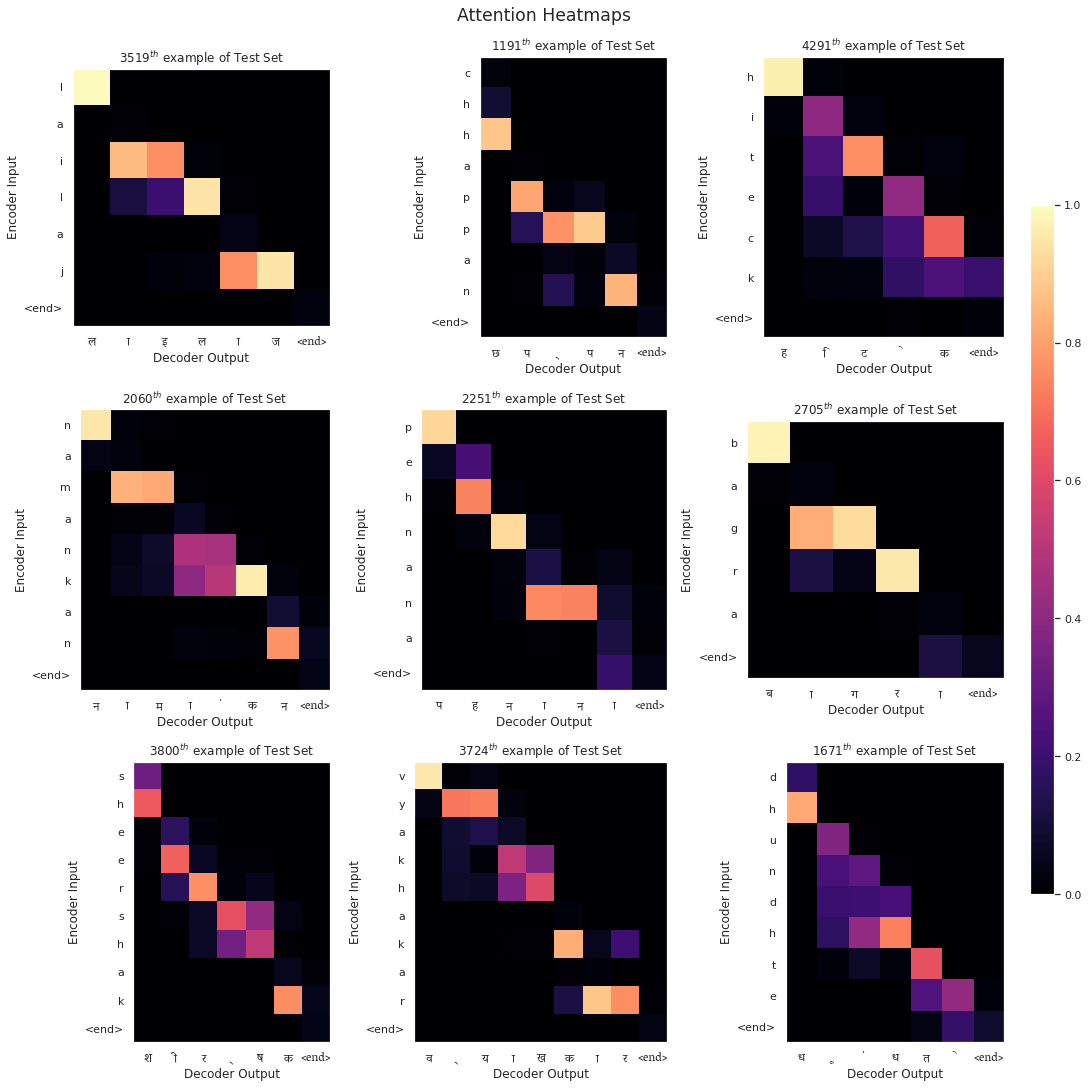

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def plot_heatmaps(input, pred_out, pred_scores, attn_scores, wandb_log=False):
    no_samples = len(pred_out)
    rand_seq = np.random.randint(no_samples, size=(9,))
    
    plt.close('all')
    fig = plt.figure(figsize=(15,15))
    fig, axes = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)
    plt.suptitle('Attention Heatmaps', fontsize='x-large')
    for i,ax in zip(rand_seq, axes.flat):
        K = len(pred_scores[i])
        k = np.argmin(pred_scores[i])
        im = ax.imshow(attn_scores[i,k,:len(pred_out[i][k])+1,:len(input[i])+1].T, vmin=0, vmax=1, cmap='magma')
        ax.set_xticks(range(len(pred_out[i][k])+1))
        ax.set_xticklabels(list(pred_out[i][k])+['<end>'], fontproperties=FontProperties(fname="/usr/share/fonts/truetype/VesperLibre-Regular.ttf"))
        ax.set_yticks(range(len(input[i])+1))
        ax.set_yticklabels(list(input[i])+['<end>'])
        ax.set_ylabel(u'Encoder Input')
        ax.set_xlabel(f'Decoder Output')
        ax.set_title(str(i) + r'$^{th}$ example of Test Set')
        ax.set_aspect("equal")
        ax.grid(False)

    # create colorbar
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
    # Log in WANDB
    if wandb_log:
        run = wandb.init(project="assignment3", entity="abisheks", reinit=True)
        wandb.log({'attention_heatmaps': fig})
        run.finish()

    plt.show()

plot_heatmaps(test2_inp, test2_pred_out, test2_pred_scores, test2_attn_scores)

In [ ]:
def print_connectivity(input, pred_out, pred_scores, attn_scores, wandb_log=False):
    return



In [ ]:
def visualize_connectivity()